No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


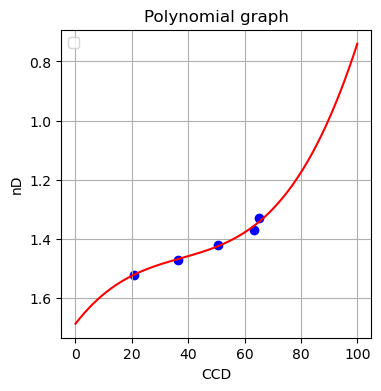

In [11]:
import tkinter as tk
from tkinter import ttk
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import statistics
from decimal import Decimal, getcontext
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# Set decimal precision context
getcontext().prec = 6

# Sample data for the nd@25 column
nd_values = [Decimal('1.33'), Decimal('1.37'), Decimal('1.42'), Decimal('1.47'), Decimal('1.52')]
delta_values = [Decimal('0.000337'), Decimal('0.000342'), Decimal('0.000404'), Decimal('0.000392'), Decimal('0.000407')]

# Prepare the main window
root = tk.Tk()
root.title("Calibrator")

# Title label for the table
title_label = tk.Label(root, text="Calibration Points", font=("Arial", 16))
title_label.grid(row=0, column=0, columnspan=6, sticky="w", padx=10, pady=(10, 5))  # Left-aligned title

# Table headers with fixed padding
headers = ["nd@25", "CCD", "t(C)", "nD(T)", "nD", "Diff"]
for i, header in enumerate(headers):
    tk.Label(root, text=header, font=("Arial", 10, "bold")).grid(row=1, column=i, pady=0, padx=5)

# Lists to store the Entry widgets for user input and calculated data
ccd_entries = []
t_entries = []
ndt_entries = []
nd_entries = []
diff_entries = []

# Populate the table with nd@25 values and entry widgets
for i, nd in enumerate(nd_values):
    # nd@25 is a fixed value, displayed in a read-only Entry widget
    nd_entry = tk.Entry(root, width=10, justify="center")
    nd_entry.grid(row=i + 2, column=0, pady=0, padx=5)  # Equal padding for rows
    nd_entry.insert(0, f"{nd:.5f}")
    nd_entry.config(state="readonly")
    
    # Editable entries for CCD and t(C)
    ccd_entry = tk.Entry(root, width=10, justify="center")
    ccd_entry.grid(row=i + 2, column=1, pady=0, padx=5)  # Equal padding for rows
    ccd_entries.append(ccd_entry)
    
    t_entry = tk.Entry(root, width=10, justify="center")
    t_entry.grid(row=i + 2, column=2, pady=0, padx=5)  # Equal padding for rows
    t_entries.append(t_entry)

    # Read-only entries for calculated nD(T), nD, and Diff
    ndt_entry = tk.Entry(root, width=10, justify="center", state="readonly")
    ndt_entry.grid(row=i + 2, column=3, pady=0, padx=5)  # Equal padding for rows
    ndt_entries.append(ndt_entry)
    
    nd_calc_entry = tk.Entry(root, width=10, justify="center", state="readonly")
    nd_calc_entry.grid(row=i + 2, column=4, pady=0, padx=5)  # Equal padding for rows
    nd_entries.append(nd_calc_entry)
    
    diff_entry = tk.Entry(root, width=10, justify="center", state="readonly")
    diff_entry.grid(row=i + 2, column=5, pady=0, padx=5)  # Equal padding for rows
    diff_entries.append(diff_entry)

# Labels for Mean diff and Max diff
mean_diff_text_label = tk.Label(root, text="Mean diff:", font=("Arial", 10, "bold"))
mean_diff_text_label.grid(row=len(nd_values) + 2, column=4, sticky="e", pady=0, padx=5)

max_diff_text_label = tk.Label(root, text="Max diff:", font=("Arial", 10, "bold"))
max_diff_text_label.grid(row=len(nd_values) + 3, column=4, sticky="e", pady=0, padx=5)

# Entry widgets for Mean diff and Max diff values
mean_diff_value = tk.Entry(root, width=10, justify="center", state="readonly")
mean_diff_value.grid(row=len(nd_values) + 2, column=5, pady=0, padx=5)

max_diff_value = tk.Entry(root, width=10, justify="center", state="readonly")
max_diff_value.grid(row=len(nd_values) + 3, column=5, pady=0, padx=5)

# Calculation function
def calculate():
    try:
        # Retrieve CCD and t(C) values, ensuring all are filled in
        ccd_values = [Decimal(entry.get()) for entry in ccd_entries if entry.get()]
        t_values = [Decimal(entry.get()) for entry in t_entries if entry.get()]

        if len(ccd_values) < len(nd_values) or len(t_values) < len(nd_values):
            print("Please fill in all CCD and t(C) values before calculating.")
            return

        # Calculate nD(T) values
        ndt_values = [nd + (Decimal('25') - t) * delta for nd, t, delta in zip(nd_values, t_values, delta_values)]

        # Polynomial regression to calculate nD values
        poly = PolynomialFeatures(degree=3)
        X = np.array([float(c) for c in ccd_values]).reshape(-1, 1)
        X_poly = poly.fit_transform(X)
        model = LinearRegression().fit(X_poly, [float(ndt) for ndt in ndt_values])

        # Get coefficients
        coefficients = [model.intercept_] + model.coef_[1:].tolist()

        # Predict nD values using model coefficients
        nD_values = [Decimal(model.predict(poly.transform([[float(c)]]))[0]).quantize(Decimal('0.00001')) for c in ccd_values]

        # Calculate Diff values and stats
        diff_values = [(nD - ndT).quantize(Decimal('0.00001')) for nD, ndT in zip(nD_values, ndt_values)]
        mean_diff = Decimal(statistics.mean(diff_values)).quantize(Decimal('0.000001'))
        max_diff = max(diff_values)

        # Update table with calculated data and apply color formatting to Diff
        any_diff_red = False  # Flag to check if any Diff is red
        for i in range(len(nd_values)):
            ndt_entries[i].config(state="normal")
            ndt_entries[i].delete(0, tk.END)
            ndt_entries[i].insert(0, f"{ndt_values[i]:.5f}")
            ndt_entries[i].config(state="readonly")
            
            nd_entries[i].config(state="normal")
            nd_entries[i].delete(0, tk.END)
            nd_entries[i].insert(0, f"{nD_values[i]:.5f}")
            nd_entries[i].config(state="readonly")
            
            diff_entries[i].config(state="normal")
            diff_entries[i].delete(0, tk.END)
            diff_entries[i].insert(0, f"{diff_values[i]:.5f}")
            # Change font color to red if Diff exceeds ±0.0004
            if abs(diff_values[i]) > Decimal('0.0004'):
                diff_entries[i].config(fg="red")
                any_diff_red = True  # Set flag if any Diff is red
            else:
                diff_entries[i].config(fg="black")
            diff_entries[i].config(state="readonly")

        # Display Mean diff and Max diff with conditional color formatting
        mean_diff_value.config(state="normal")
        mean_diff_value.delete(0, tk.END)
        mean_diff_value.insert(0, f"{mean_diff:.6f}")
        mean_diff_value.config(fg="red" if any_diff_red else "black", state="readonly")
        
        max_diff_value.config(state="normal")
        max_diff_value.delete(0, tk.END)
        max_diff_value.insert(0, f"{max_diff:.5f}")
        max_diff_value.config(fg="red" if abs(max_diff) > Decimal('0.0004') else "black", state="readonly")

        # Update the plot
        update_plot(coefficients)

    except ValueError:
        print("Please enter valid numeric values for CCD and t(C) fields.")

# Function to update the polynomial graph
def update_plot(coefficients):
    lower_limit = 0
    upper_limit = 100
    num_pts = 1000
    x = np.linspace(lower_limit, upper_limit, num_pts)
    
    poly_coefs = coefficients[::-1]  # [4, 3, 2, 1]
    y = np.polyval(poly_coefs, x)

    # Clear previous plot
    ax.clear()

    # Plot the polynomial
    ax.plot(x, y, '-r')

    # Adding points to the plot
    x_points = [float(entry.get()) for entry in ccd_entries if entry.get()]
    y_points = [(nd + (Decimal('25') - Decimal(t.get())) * delta).quantize(Decimal('0.00001')) for nd, t, delta in zip(nd_values, t_entries, delta_values) if t.get()]

    ax.scatter(x_points, y_points, color='blue')

    # Invert y-axis
    ax.invert_yaxis()

    # Add labels and title
    ax.set_xlabel('CCD')
    ax.set_ylabel('nD')
    ax.set_title('Polynomial graph')

    # Add grid
    ax.grid(True)

    # Add legend
    ax.legend()

    # Refresh the canvas
    canvas.draw()

# Create a figure for the polynomial graph
fig, ax = plt.subplots(figsize=(4, 4), dpi=100)

# Create a canvas to embed the plot in Tkinter
canvas = FigureCanvasTkAgg(fig, master=root)
canvas.get_tk_widget().grid(row=2, column=6, rowspan=len(nd_values) + 4, sticky="nsew")

# Configure fixed grid resizing for the table
for i in range(len(nd_values) + 4):
    root.grid_rowconfigure(i + 2, minsize=30)  # Set minimum row height for table rows
root.grid_columnconfigure(0, weight=0)  # Disable column expansion for the table
root.grid_columnconfigure(1, weight=0)  # Disable column expansion for the table
root.grid_columnconfigure(2, weight=0)  # Disable column expansion for the table
root.grid_columnconfigure(3, weight=0)  # Disable column expansion for the table
root.grid_columnconfigure(4, weight=0)  # Disable column expansion for the table
root.grid_columnconfigure(5, weight=0)  # Disable column expansion for the table

# Configure column for the plot to allow expansion
root.grid_columnconfigure(6, weight=1)  # Enable column expansion for the plot

# Add button to calculate results
calc_button = tk.Button(root, text="Calculate", command=calculate)
calc_button.grid(row=len(nd_values) + 4, column=0, columnspan=6, pady=10)


# Run the Tkinter main loop
root.mainloop()
